# Advanced Lane Finding Project

 **The goals / steps of this project are the following:** 

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position

## 1. Camera Calibration and Distortion Correction
* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.

In [7]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import glob

class CameraCalibrator():
    """
    Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
    Apply a distortion correction to raw images
    """
    def __init__(self):
        
        self.mtx, self.dist = self.calculate_mtx_dist()
        
    def calculate_mtx_dist(self):
    
        # prepare object points
        objp = np.zeros((9*6, 3), np.float32)
        objp[:, :2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)
        
        # arrays to store object points and image points 
        objpoints = []
        imgpoints = []

        # make a list of calibration images
        images = glob.glob(os.path.join('camera_cal', "calibration*.jpg"))

        for idx, fname in enumerate(images):
            img = cv2.imread(fname)
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            
            # find the chessboard corners
            ret, corners = cv2.findChessboardCorners(img, (9, 6), None)
    
            # If found, draw corners
            if ret == True:
                objpoints.append(objp)
                imgpoints.append(corners)
               
        # do camera calibration under the object points and image points
        image_size = (img.shape[1], img.shape[0])
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, image_size, None, None)
        
        return mtx, dist
        
    def undistort(self, image):
        undist = cv2.undistort(image, self.mtx, self.dist, self.mtx)
        return undist       

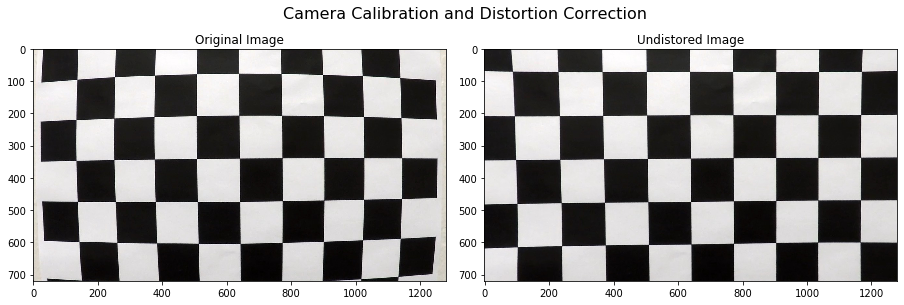

In [5]:
# Display and store chessboard  image
image = mpimg.imread("camera_cal/calibration1.jpg")
camera_calibrator = CameraCalibrator()
undistort = camera_calibrator.undistort(image)

f, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 4))
f.tight_layout()
ax1.imshow(image)
ax1.set_title("Original Image", fontsize = 12)

ax2.imshow(undistort)
ax2.set_title("Undistored Image", fontsize = 12)
plt.tight_layout()
plt.subplots_adjust(left = 0, right = 1, top = 0.9, bottom = 0.)
plt.suptitle("Camera Calibration and Distortion Correction", y = 1.0, fontsize=16)
plt.savefig("output_images/1_undistort.jpg", bbox_inches='tight')

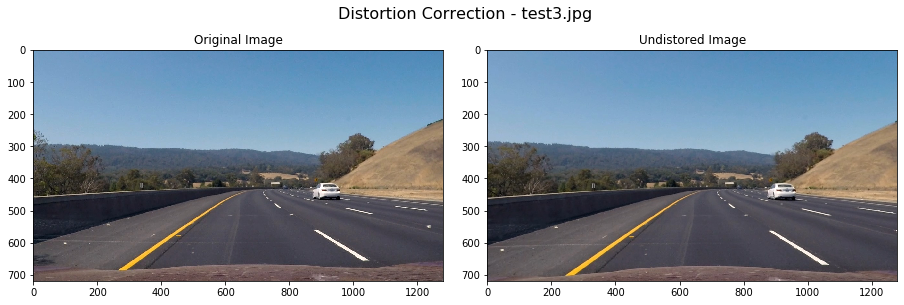

In [6]:
# Display and store chessboard  image
image = mpimg.imread("test_images/test3.jpg")
camera_calibrator = CameraCalibrator()
undistort = camera_calibrator.undistort(image)

f, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 4))
f.tight_layout()
ax1.imshow(image)
ax1.set_title("Original Image", fontsize = 12)

ax2.imshow(undistort)
ax2.set_title("Undistored Image", fontsize = 12)
plt.subplots_adjust(left = 0, right = 1, top = 0.9, bottom = 0.)
plt.suptitle("Distortion Correction - test3.jpg", y = 1.0, fontsize=16)
plt.savefig("output_images/1_undistort_test3.jpg", bbox_inches='tight')

## 2. Color, Gradient Magnitude and Direction Threshold to binary image
* Use color transforms, gradients, etc., to create a thresholded binary image.

In [8]:
import cv2
import numpy as np


class BinaryThresholder():
    '''Create a binary threshold image for detecting lane lines'''
    
    def combined_binary(self, img):
        '''Create a binary threshold image and apply it to self.image'''
        
        # Apply color thresh
        color_binary = color_tresh(img, s_thresh = (120, 255), v_thresh = (50, 255))
      
        # Sobel_x thresh
        gradx = abs_sobel_tresh(img, orient = 'x', thresh = (20, 255)) 
        grady = abs_sobel_tresh(img, orient = 'y', thresh = (25, 255))
      
        # extract yellow
        ylw = extract_yellow(img)
      
        # combined thresholdy
        combined_binary = np.zeros_like(color_binary)
        
        combined_binary[((gradx == 1) & (grady == 1)) | (color_binary == 1) | (ylw == 255)] = 1
                        
        # Apply a mask to select intresting
        binary = region_of_interest(combined_binary)
        return binary
    
def color_tresh(img, s_thresh = (0, 255), v_thresh = (0, 255)):
    """
    Apply a thresh to colors, return binary image.
    """
    
    # Extract s color
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s = hls[:, :, 2]
    s_binary = np.zeros_like(s)
    s_binary[(s >= s_thresh[0]) & (s <= s_thresh[1])] = 1
    
    # Extract v color
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    v = hsv[:, :, 2]
    v_binary = np.zeros_like(v)
    v_binary[(v > v_thresh[0]) & (v <= v_thresh[1])] = 1
    
    output = np.zeros_like(v)
    output[(s_binary == 1) & (v_binary == 1)] = 1
    
    return output
    
    
def abs_sobel_tresh(img, orient = 'x', sobel_kernel = 3, thresh = (0, 255)):
    """ 
    Define a function that applies Sobel x or y, and then apply a thresh.
    return a binary image.
    """
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    elif orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))

    scaled_sobel = np.uint8(255*abs_sobel / np.max(abs_sobel))
    
    binary_output = np.zeros_like(scaled_sobel)
    
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    return binary_output
    
def extract_yellow(image):
    """
    Extract the yellow color.
    """
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    return cv2.inRange(hsv, (26, 43, 46), (34, 255, 255))

def region_of_interest(image):
    '''
    Applies an image mask. Only keeps the region of the image defined by the polygon formed from `vertices`. 
    The rest of the image is set to black
    '''
    img_size = image.shape[:2]
    vertices = np.array([[(img_size[1] / 2 - 30, img_size[0] / 2 + 80), # top left
                          (0, img_size[0]),                              # bottom left
                          (img_size[1], img_size[0]),                    # bottom right
                          (img_size[1] / 2 + 80, img_size[0] / 2 + 80)]], dtype=np.int32)  # bottom right


    mask = np.zeros_like(image)

    # Define a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(image.shape) > 2:
        channel_count = image.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    # Fill pixels inside the polygon defined by "vertices" with the fill color (i.e. white)
    cv2.fillPoly(mask, vertices, ignore_mask_color)

    # Return the image only where mask pixels are nonzero
    return cv2.bitwise_and(image, mask)

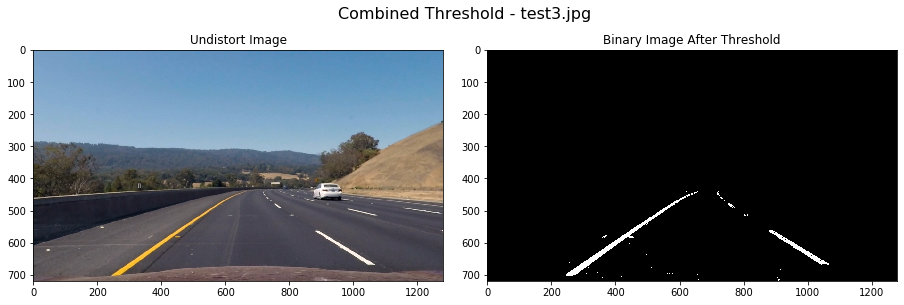

In [8]:
# Display and store output image
image = mpimg.imread("test_images/test3.jpg")
camera_calibrator = CameraCalibrator()
undistort = camera_calibrator.undistort(image)

# Apply threshold 
binary = BinaryThresholder()
combined_binary = binary.combined_binary(undistort)

f, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 4))
f.tight_layout()
ax1.imshow(undistort)
ax1.set_title("Undistort Image", fontsize = 12)
ax2.imshow(combined_binary, cmap = 'gray')
ax2.set_title("Binary Image After Threshold", fontsize =12)
plt.subplots_adjust(left = 0, right = 1, top = 0.9, bottom = 0.)
plt.suptitle("Combined Threshold - test3.jpg", y = 1.0, fontsize=16)
plt.savefig("output_images/2_Combined_threshold.jpg", bbox_inches='tight')

## 3. Apply a perspective transform to rectify binary image ("birds-eye view").

In [9]:
import numpy as np
import cv2

class PerspectiveTransfromer():
    """
    Compute the perspective transform, M, given source and destination points
    """
    def __init__(self):
        
        # The original image size
        img_size = (720, 1280)
        
        # source points
        self.src = np.float32(
            [[(img_size[1] / 2) - 60, img_size[0] / 2 + 100],
            [((img_size[1] / 6) - 10), img_size[0]],
            [(img_size[1] * 5 / 6) + 60, img_size[0]],
            [(img_size[1] / 2 + 60), img_size[0] / 2 + 100]])
        
        #destination points
        self.dst = np.float32(
            [[(img_size[1] / 4), 0],
            [(img_size[1] / 4), img_size[0]],
            [(img_size[1] * 3 / 4), img_size[0]],
            [(img_size[1] * 3 / 4), 0]])
        
        
        self.M = cv2.getPerspectiveTransform(self.src, self.dst)
        self.Minv = cv2.getPerspectiveTransform(self.dst, self.src)
        
    def warp(self, image):
        warped = cv2.warpPerspective(image, self.M, (image.shape[1], image.shape[0]), 
                                     flags=cv2.INTER_LINEAR)
        return warped 

### 3.1 Apply Straight lines

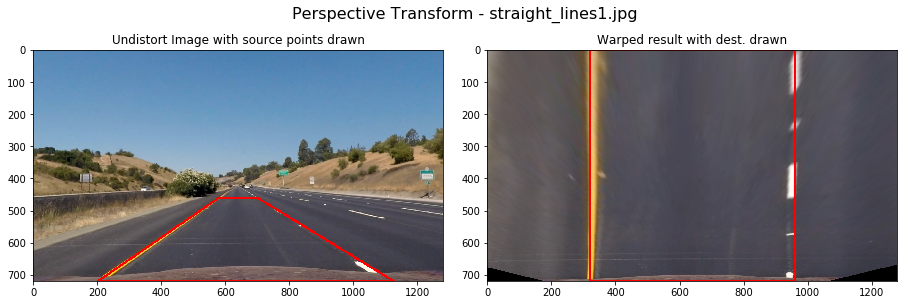

In [10]:
# display and store output image
image = mpimg.imread("test_images/straight_lines1.jpg")
camera_calibrator = CameraCalibrator()
undistort = camera_calibrator.undistort(image)

# apply threshold 
# binary = BinaryThresholder(undistort)
# binary_combined = binary.threshold_image()

# perspective transform

transformer = PerspectiveTransfromer()
warped = transformer.warp(undistort)

cv2.polylines(undistort, [transformer.src.astype(int)], True, (255, 0, 0),5)
cv2.polylines(warped, [transformer.dst.astype(int)], True, (255, 0, 0),5)

f, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 4))
f.tight_layout()

ax1.imshow(undistort)
ax1.set_title("Undistort Image with source points drawn", fontsize = 12)
ax2.imshow(warped, cmap='gray')
ax2.set_title("Warped result with dest. drawn", fontsize = 12)
plt.subplots_adjust(left = 0, right = 1, top = 0.9, bottom = 0.)
plt.suptitle("Perspective Transform - straight_lines1.jpg", y = 1.0, fontsize=16)
plt.savefig("output_images/3_PerspectiveTransform_straight.jpg", bbox_inches='tight')

### 3.2 Apply curve lines

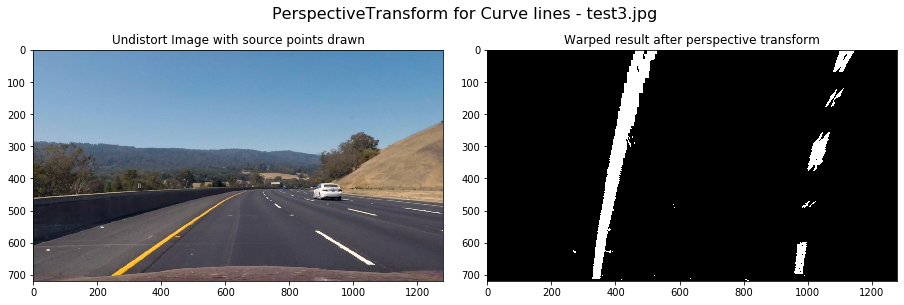

In [11]:
# display and store output image
image = mpimg.imread("test_images/test3.jpg")
camera_calibrator = CameraCalibrator()
undistort = camera_calibrator.undistort(image)

#apply threshold 
binary = BinaryThresholder()
combined_binary = binary.combined_binary(undistort)

# perspective transform
transformer = PerspectiveTransfromer()
warped = transformer.warp(combined_binary)

#cv2.polylines(undistort, [transformer.src.astype(int)], True, (255, 0, 0),5)
#cv2.polylines(warped, [transformer.dst.astype(int)], True, (255, 0, 0),5)

f, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 4))
f.tight_layout()

ax1.imshow(undistort)
ax1.set_title("Undistort Image with source points drawn", fontsize = 12)
ax2.imshow(warped, cmap='gray')
ax2.set_title("Warped result after perspective transform", fontsize = 12)
plt.subplots_adjust(left = 0, right = 1, top = 0.9, bottom = 0.)
plt.suptitle("PerspectiveTransform for Curve lines - test3.jpg", y = 1.0, fontsize=16)
plt.savefig("output_images/4_PerspectiveTransform_curve.jpg", bbox_inches='tight')

## 4. Detect lane pixels and fit to find the lane boundary and compute the boundary.

In [10]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# HYPERPARAMETERS
# Choose the number of sliding windows
NWINDOWS = 9
# Set the width of the windows +/- margin
MARGIN = 100
# Set minimum number of pixels found to recenter window
MINPIX = 50

# Define conversions in x and y from pixels space to meters
YM_PER_PIX = 30/720 # meters per pixel in y dimension
XM_PER_PIX = 3.7/700 # meters per pixel in x dimension

class Line():
    """
     1. Find the best fit of left and right lane lines through sliding windows. 
     2. Once found the lane lines in one frame of video, and then search within a window around the previous detection.
     3. Smooth the lane fit line though taking an average over n past measurements. 
     3. Once get a good measurement of the line positions in warped space, 
        and draw back on the road with curvature and car position
    """
    def __init__(self, n_frame=1, smooth_factor = 50):
        
        # Taking an average over 'smooth_factor' past measurement
        self.smooth_factor = smooth_factor
        
        # when n_frame = 1, search lanes through sliding windows.
        # Otherwise, search around the previous measurements. 
        self.n_frame = n_frame
        
        # x values of the last n fits of the line tp smooth the detected lines
        self.recent_xfitted = [] 
        
        # The x coordinates of detected pixels on left lane line 
        self.leftx = None
        # The y coordinates of detected pixels on left lane line 
        self.lefty = None
        # The x coordinates of detected pixels on right lane line 
        self.rightx = None
        # The y coordinates of detected pixels on right lane line 
        self.righty = None
        
        # Through above four avariables, we can get the x coordiante of the best fitted polynominal
        self.best_left_fitx = None
        self.best_right_fitx = None
        
        
    def find_best_fitx(self, warped):
        """
        Find the x coordinates of the best fitted polynominal about lane lines.
        """
        # n_frame =1 means that we can get the best fitted x through sliding windows
        if self.n_frame == 1:
            # Using the function 'find_lane_pixels' that is the silding window method to 
            # get the pixels' coordinates of lane lines
            self.leftx, self.lefty, self.rightx, self.righty, _ = find_lane_pixels(warped)
            
            # Get the polynomial x coordinate 
            left_fitx, right_fitx, ploty = generate_fitx(warped, self.leftx, self.lefty, self.rightx, self.righty)
            
            # Append the polynomial x coordinate to the list so that we can smooth the 
            # lane lines by averaging previous 15 frames
            self.recent_xfitted.append((left_fitx, right_fitx))
            
            # Find the best fitted x coordinates of lane lines
            self.best_left_fitx = left_fitx
            self.best_right_fitx = right_fitx
            
        elif self.n_frame > 1:
            
            # n_frame > 1 means that we can get the best fitted x through searching around priors.
            self.leftx, self.lefty, self.rightx, self.righty = search_from_prior(warped, self.leftx, self.lefty, self.rightx, self.righty)
        
            # Get the polynomial x coordinate 
            left_fitx, right_fitx, ploty = generate_fitx(warped, self.leftx, self.lefty, self.rightx, self.righty)
            # Append the polynomial x coordinate to the list so that we can smooth the 
            # lane lines by averaging previous 15 frames
            self.recent_xfitted.append((left_fitx, right_fitx))
            # Average the measuremtnts of previous 15 frames as the current best values.
            best_xfitted = np.average(self.recent_xfitted[-self.smooth_factor:], axis = 0)

            # Find the best fitted x coordinates of lane lines
            self.best_left_fitx = best_xfitted[0]
            self.best_right_fitx = best_xfitted[1]


    def plot_line_on_warp(self, warped):
        """
        Draw the best fitted lines on warped image.
        """
        # Define the y coordinates
        ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0])

        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((warped, warped, warped))*255

        # Draw the left line using the cv2.polylines
        left_curve = np.column_stack((self.best_left_fitx, ploty))
        right_curve = np.column_stack((self.best_right_fitx, ploty))
        cv2.polylines(out_img, np.int_([left_curve]), False, (255,0,0), 10)
        cv2.polylines(out_img, np.int_([right_curve]), False, (0,0,255), 10)

        return out_img

    def inversed_warp(self, warped, undistort, Minv):
        """
        Draw the best fitted lines on the warp image and project measurements back down onto the road 
        with the curvatures and car position to the lane center.
        """

        ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0])

        # Create an image to draw the lines on
        warp_zero = np.zeros_like(warped).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([self.best_left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([self.best_right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
        
        # Draw the left and right lane lines
        left_curve = np.column_stack((self.best_left_fitx, ploty))
        right_curve = np.column_stack((self.best_right_fitx, ploty))
        cv2.polylines(color_warp, np.int_([left_curve]), False, (255,0,0), 10)
        cv2.polylines(color_warp, np.int_([right_curve]), False, (0,0,255), 10)

        # Project measurements back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, Minv, (undistort.shape[1], undistort.shape[0])) 
        # Combine the result with the original image
        result = cv2.addWeighted(undistort, 1, newwarp, 0.5, 0)
        
        # Compute the position of the car
        image_center_x = warped.shape[1] / 2
        lane_center_x = (self.best_left_fitx[-1] + self.best_right_fitx[-1]) / 2
        offset = (lane_center_x - image_center_x)*XM_PER_PIX
        
        # Get the line curvature
        left_curvature, right_curvature = self.getCurvature(warped)

        # Add curvature and offset information on the final image
        text = "{:.3f}km".format(left_curvature/1000.)
        cv2.putText(result, "Left curvature = " + text, (50, 50), cv2.FONT_HERSHEY_DUPLEX, 2, (255, 255, 255), 3)

        text = "{:.3f}km".format(right_curvature/1000.)
        cv2.putText(result, "Right curvature = " + text, (50, 120), cv2.FONT_HERSHEY_DUPLEX, 2, (255, 255, 255), 3)

        left_right = 'left' if offset < 0 else 'right'
        cv2.putText(result, "Vehicle is " + str(abs(round(offset, 3))) + "m " + left_right + " of center",(50, 190),
                   cv2.FONT_HERSHEY_DUPLEX, 2, (255, 255, 255), 3)

        # Visulization of image center and lane center
        cv2.line(result, (int(lane_center_x), result.shape[0]), (int(lane_center_x), result.shape[0] - 20), 
                 (255, 255, 255), 6)
        cv2.line(result, (int(image_center_x), result.shape[0]), (int(image_center_x), result.shape[0] - 40), 
                 (255, 255, 255), 6)
        cv2.line(result, (int(lane_center_x), result.shape[0] - 2), (int(image_center_x), result.shape[0] - 2), 
                 (255, 255,255), 6)

        return result


    def getCurvature(self, warped):
        """
        Compute the real curvature of detected lane lines
        """

        leftx = self.best_left_fitx[::-1]  # Reverse to match top-to-bottom in y
        rightx = self.best_right_fitx[::-1]  # Reverse to match top-to-bottom in y

        ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0])

        # Fit a second order polynomial to pixel positions in each fake lane line
        left_fit_cr = np.polyfit(ploty * YM_PER_PIX, leftx* XM_PER_PIX, 2)
        right_fit_cr = np.polyfit(ploty * YM_PER_PIX, rightx * XM_PER_PIX, 2)

        # Define y-value where we want radius of curvature
        # We'll choose the maximum y-value, corresponding to the bottom of the image
        y_eval = np.max(ploty) * YM_PER_PIX


        # Calculation of R_curve (radius of curvature)
        left_curvature = (1 + (2*left_fit_cr[0]*y_eval + left_fit_cr[1])**2)**1.5 / np.abs(2*left_fit_cr[0]) 
        right_curvature = (1 + (2*right_fit_cr[0]*y_eval + right_fit_cr[1])**2)**1.5 / np.abs(2*right_fit_cr[0]) 


        return(left_curvature, right_curvature) 
    

#######
# Below, functions which are used to the Line Class.
#######
        
def find_lane_pixels(warped):
    """
    Implement Sliding Windows
    """

    # Take a histogram of the bottom half of the image
    histogram = np.sum(warped[warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((warped, warped, warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(warped.shape[0]//NWINDOWS)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(NWINDOWS):
        
        win_y_low = warped.shape[0] - (window+1)*window_height
        win_y_high = warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - MARGIN  
        win_xleft_high = leftx_current + MARGIN  
        win_xright_low = rightx_current - MARGIN  
        win_xright_high = rightx_current + MARGIN  
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 5) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 5) 

        #Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy > win_y_low) & (nonzeroy < win_y_high) & (nonzerox > win_xleft_low) & 
                          (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy > win_y_low) & (nonzeroy < win_y_high) & (nonzerox > win_xright_low) &
                           (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        ### If you found > minpix pixels, recenter next window
        if good_left_inds.sum() > MINPIX:
            leftx_current = int(nonzerox[good_left_inds].mean())
        if good_right_inds.sum() > MINPIX:
            rightx_current = int(nonzerox[good_right_inds].mean())

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    

    return leftx, lefty, rightx, righty, out_img

def fit_polynomial(warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(warped)

    ### Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    curve1 = np.column_stack((left_fitx, ploty))
    curve2 = np.column_stack((right_fitx, ploty))
    cv2.polylines(out_img, np.int_([curve1, curve2]), False, (0,255,255), 5)

    return out_img

def search_from_prior(warped, leftx, lefty, rightx, righty):
    """
    Find lane pixles' coordinates of the the current frame through searching the previous measurements
    """
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Grab activated pixels
    nonzero = warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    ### n the previous quiz, but change the windows to our new search area
    left_lane_inds = (nonzerox > (left_fit[0] * nonzeroy ** 2 + left_fit[1] * nonzeroy +
    left_fit[2] - MARGIN)) & (nonzerox < (left_fit[0] * nonzeroy ** 2 + 
    left_fit[1] * nonzeroy + left_fit[2] + MARGIN))
    right_lane_inds = (nonzerox > (right_fit[0] * nonzeroy ** 2 + right_fit[1] * nonzeroy +
    right_fit[2] - MARGIN)) & (nonzerox < (right_fit[0] * nonzeroy ** 2 + 
    right_fit[1] * nonzeroy + right_fit[2] + MARGIN))

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty


def generate_fitx(warped, leftx, lefty, rightx, righty):

    #Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0])

    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    return left_fitx, right_fitx, ploty

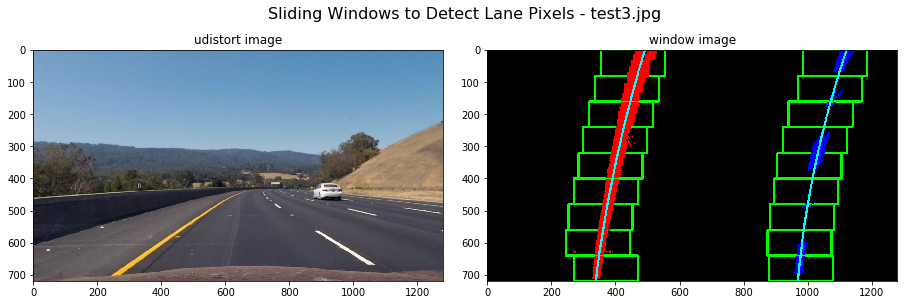

In [13]:
# display and store output image
image = mpimg.imread("test_images/test3.jpg")
camera_calibrator = CameraCalibrator()
undistort = camera_calibrator.undistort(image)

#apply threshold 
binary = BinaryThresholder()
combined_binary = binary.combined_binary(undistort)

# perspective transform
transformer = PerspectiveTransfromer()
warped = transformer.warp(combined_binary)

 # sliding window image

window_img = fit_polynomial(warped)

f, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 4))
f.tight_layout()

ax1.imshow(undistort)
ax1.set_title("udistort image", fontsize = 12)
ax2.imshow(window_img, cmap='gray')
ax2.set_title("window image", fontsize = 12)
plt.subplots_adjust(left = 0, right = 1, top = 0.9, bottom = 0.)
plt.suptitle("Sliding Windows to Detect Lane Pixels - test3.jpg", y = 1.0, fontsize=16)
plt.savefig("output_images/4_2_sliding_windows_test3.jpg", bbox_inches='tight')

## 5. Processing the test images

In [11]:
############
## Pipeline for image
############
## For the image, the pipeline should be search through slinding window method to find best line
## For video, best lines were found through sliding window on first frame.
## But, Simply search best line within a window around the previous frame results.
## So the pipeline for image and vedio was different.

# Instantiate the classes.
# The camera calibraton and perpective transform should be done once with all images.
calibrator = CameraCalibrator()
binary = BinaryThresholder()
transformer = PerspectiveTransfromer()
line = Line()

def precess_image(img):
    # Undisort the image
    undistort = calibrator.undistort(img)

    #Apply threshold to the undistort image
    combined_binary = binary.combined_binary(undistort)

    # perspective transform to get the warped image
    warped = transformer.warp(combined_binary)
    
    # sliding window image
    window_img = fit_polynomial(warped)
    
   
    line.find_best_fitx(warped)
    road_image = line.inversed_warp(warped, undistort, transformer.Minv)
   
    return undistort, window_img, road_image

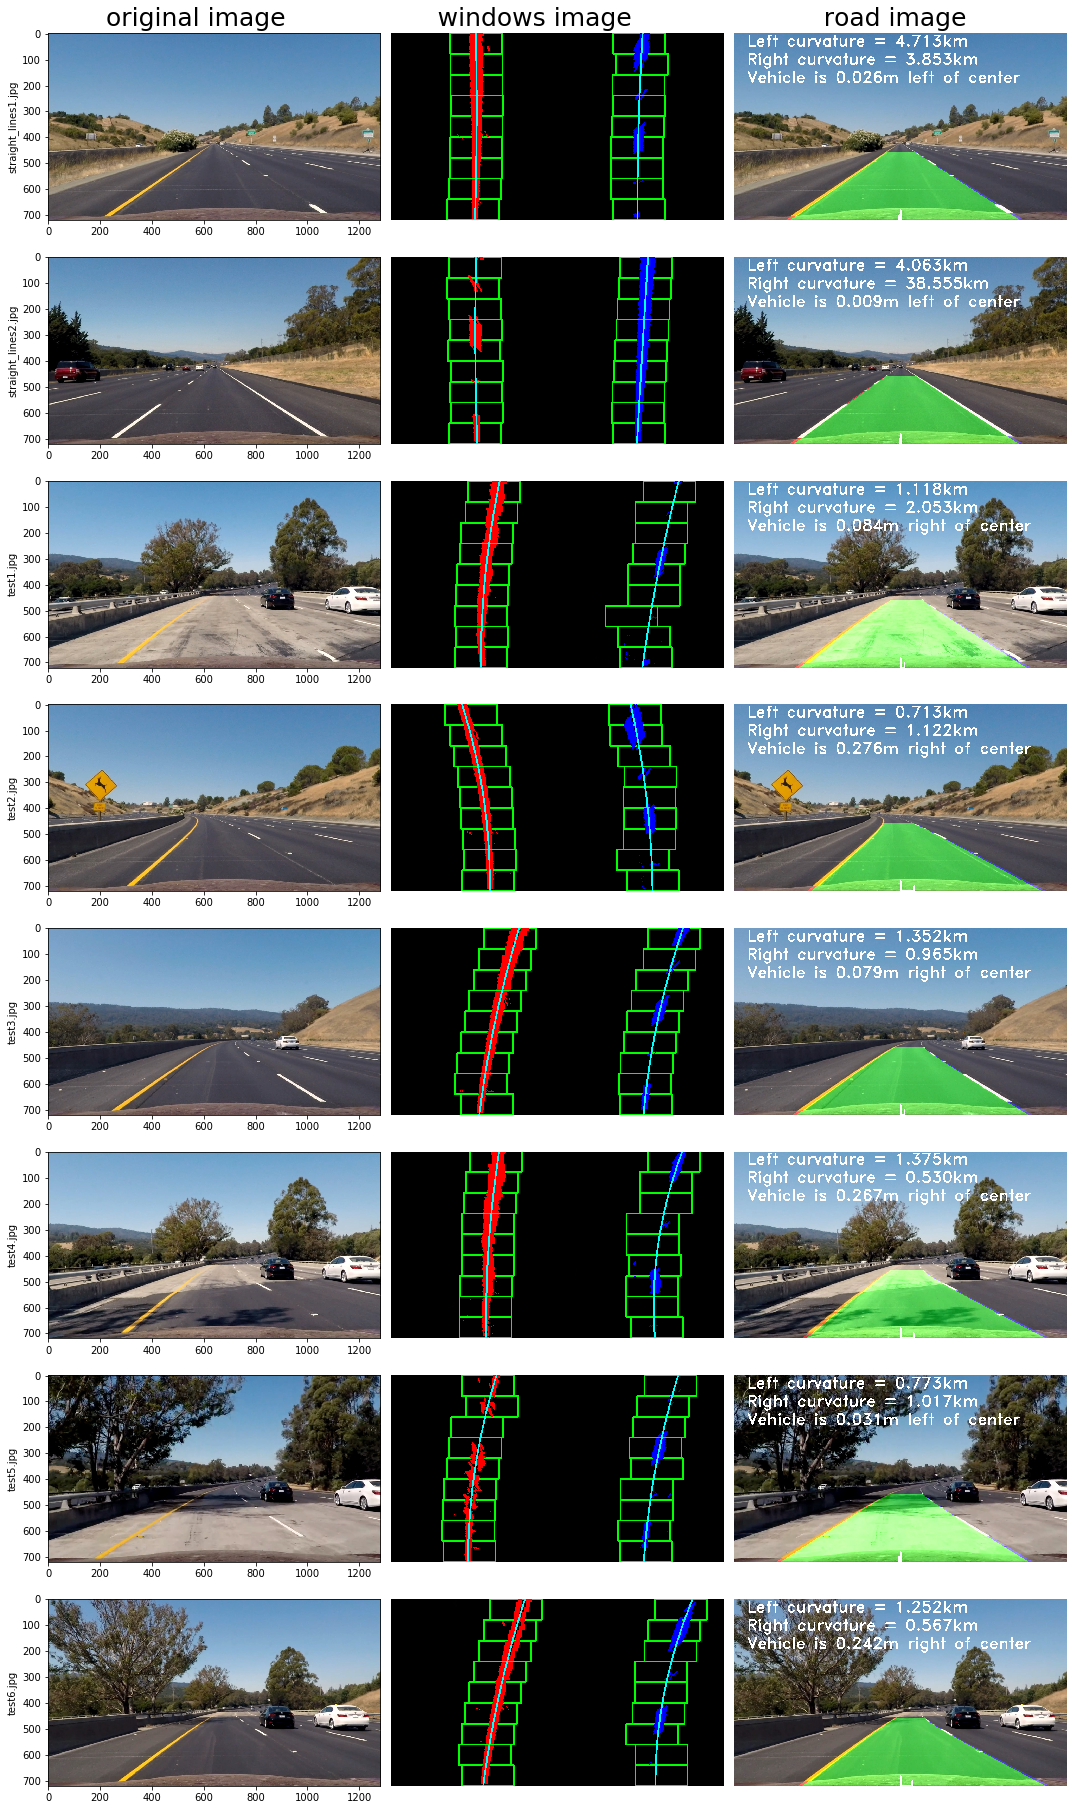

In [23]:
test_images = glob.glob(os.path.join('test_images', "*.jpg"))
fig, axis = plt.subplots(len(test_images), 3, figsize = (15, 25))
for row, image_path in enumerate(test_images):
    img = mpimg.imread(image_path)
    undistort, window_img, road_img = precess_image(img)
    # Display undistort image, searching window image and road image every row
    axis[row, 0].imshow(undistort)
    #axis[row, 0].axis("off")
    axis[row, 0].set_ylabel(image_path.split("\\")[-1])
    
    axis[row, 1].imshow(window_img)
    axis[row, 1].axis("off")
    
    axis[row, 2].imshow(road_img)
    axis[row, 2].axis("off")
    
plt.tight_layout()
plt.suptitle("original image                   windows image                        road image", y = 1.005, fontsize=25)
plt.savefig("output_images/all_test_images.jpg", bbox_inches = 'tight')
plt.show()

## 6. Processing vedio

In [6]:
############
## Pipeline for image
############
## For the image, the pipeline should be search through slinding window method to find best line
## For video, best lines were found through sliding window on first frame.
## But, Simply search best line within a window around the previous frame results.
## So the pipeline for image and vedio was different.

# Instantiate the classes.
# The camera calibraton and perpective transform should be done once with all images.
calibrator = CameraCalibrator()
binary = BinaryThresholder()
transformer = PerspectiveTransfromer()
# When instantiate the Line Class here, n_frame must be equal to 1.
# This means the first frame makes use of the sliding window method.
# 'smooth_factor' means I use how many frames to smooth the current measurement.But it shoule not be too bigger, or 
# it may accumulates the previous errors. Within 10, the result is good.
line = Line(n_frame=1, smooth_factor=5)

def process_frame(img):
    # Undisort the image
    undistort = calibrator.undistort(img)

    #Apply threshold to the undistort image
    combined_binary = binary.combined_binary(undistort)

    # perspective transform to get the warped image
    warped = transformer.warp(combined_binary)
    
    # plot lines on warped image.
    # This is different from the image pipeline
    line.find_best_fitx(warped)
    line_image = line.plot_line_on_warp(warped)
    road_image = line.inversed_warp(warped, undistort, transformer.Minv)
    
    result = plot_diagnostics(undistort, combined_binary, line_image, road_image)
    
    # This can control the function find_best_fitx of Class Line to select to search best line from priors.
    line.n_frame += 1
    
    # print(len(line.recent_xfitted))
    # print(line.n_frame)
    
    return result
    

def plot_diagnostics(undst_img, thres_img, line_img, road_img):
    '''Plot a number of images created by the pipeline into a single image'''
    
    diagScreen = np.zeros((960, 1280, 3), dtype=np.uint8)

    # Main screen
    diagScreen[0:720, 0:1280] = road_img

    # Four screens along the bottom
    diagScreen[720:960, 0:426] = cv2.resize(undst_img, (426, 240), interpolation=cv2.INTER_AREA)        # undistorted         

    color_thresh = np.dstack((thres_img, thres_img, thres_img)) * 255
    diagScreen[720:960, 426:852] = cv2.resize(color_thresh, (426, 240), interpolation=cv2.INTER_AREA)   # binary
    # threshold image

    diagScreen[720:960, 852:1278] = cv2.resize(line_img, (426, 240), interpolation=cv2.INTER_AREA)    # birds-eye with best line
    # view of the binary threshold image

    return diagScreen

### 6.1 Process an image using the video pipeline

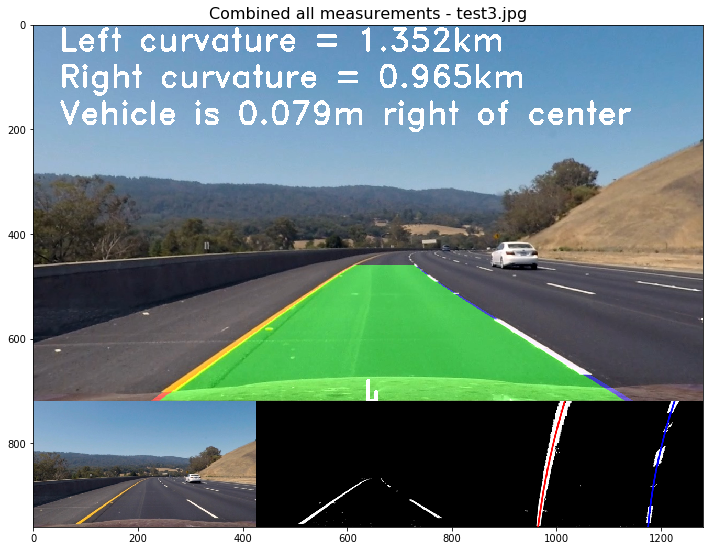

In [14]:
image = mpimg.imread("test_images/test3.jpg")
result = process_frame(image)

fig = plt.figure(figsize = (12, 12))
plt.imshow(result)
plt.title("Combined all measurements - test3.jpg", fontsize=16)
plt.savefig("output_images\5_Combined_all_test3.jpg")

### 6.2 Process the veido: project_video.mp4

In [7]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
output = 'project_video_output.mp4'

clip1 = VideoFileClip('project_video.mp4')
out_clip = clip1.fl_image(process_frame)

%time out_clip.write_videofile(output, audio=False)

Moviepy - Building video project_video_output.mp4.
Moviepy - Writing video project_video_output.mp4



Moviepy - Done !
Moviepy - video ready project_video_output.mp4
Wall time: 6min 11s


### 6.3 compute my pipeline velocity

In [9]:
total_frames = line.n_frame
total_time = 371 # s
smooth_factor = total_frames / total_time # FPS
print("The velocity of my pipeline: {} FPS".format(round(smooth_factor, 1)))

The velocity of my pipeline: 3.4 FPS
